In [68]:
import pandas as pd
import numpy as np

from utils.main_support import selectCol, getPath
from utils.static import protein_seq
from utils.sequence import sequence_mapping_str

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import params.filePath as paramF
import params.hyperparams as paramH

In [26]:
# get file path
path_train, path_test = getPath(paramH.datasetType)
# Load the data
train_data = pd.read_json(path_train, orient='records', dtype=False)
test_data = pd.read_json(path_test, orient='records', dtype=False)

# select columns
train_data, test_data = selectCol(train_data, test_data, paramH.datasetType)

In [27]:
def count_num(num_AAisIDR, seq, ref):
    num_IDR = 0 
    num_aa = len(seq)
    for i in range(num_aa):
        if int(ref[i])==1:
            num_AAisIDR[seq[i]] = num_AAisIDR[seq[i]] + 1
            num_IDR = num_IDR + 1
    return num_AAisIDR, num_IDR, num_aa

In [4]:
def calculate_prob(df_data):
    '''
    calculate the probability to be disordered for each amino acid
    params:
        df_data
    '''
    prob_AAisIDR = {aa:0.0 for aa in protein_seq.amino_acids}
    num_AAisIDR = {aa:0 for aa in protein_seq.amino_acids}
    
    num_aa = 0
    num_IDR = 0
    for idx, row in train_data.iterrows():
        seq = sequence_mapping_str(row['sequence']) # replace rare AAs with X
        ref = row['reference']
        num_AAisIDR, num_IDR_1, num_aa_1 = count_num(num_AAisIDR, seq, ref)
        num_aa = num_aa + num_aa_1
        num_IDR = num_IDR + num_IDR_1
        
    prob_AAisIDR = {k:num_AAisIDR[k]/num_aa for k in num_AAisIDR.keys()}
    return prob_AAisIDR, num_AAisIDR, num_aa, num_IDR

In [15]:
def predict_one_sequence(prob_AAisIDR, seq):
    '''
    predict one protein sequence.
    params:
        prob_AAisIDR - {'aa1': prob, ...}
        seq - str, AMCDLASP...
    return:
        pre_idr - list, [0.1, 0.32, 0.05, ....]
    '''
    pre_idr = [prob_AAisIDR[aa] for aa in seq]
    return pre_idr

def predict_test(prob_AAisIDR, df_test):
    '''
    Assign the probability of each AA being disordered to all the sequences, and generate the prediction.
    params:
        prob_AAisIDR - {'aa1': prob, ...}
        df_test - dataframe, columns: id (pdbID_entityID), sequence, reference.
    return:
        list_pred - list, pretions
        list_label - list, ground truth.
    '''
    list_pred = []
    list_label = []
    for _, row in df_test.iterrows():
        seq = sequence_mapping_str(row['sequence'])
        ref = row['reference']
        list_label = list_label + [int(r) for r in ref]
        list_pred = list_pred + predict_one_sequence(prob_AAisIDR, seq)

    return list_pred, list_label

In [42]:
num_AAisIDR, num_aa, num_IDR

({'A': 30063,
  'C': 2933,
  'D': 22011,
  'E': 28864,
  'F': 8711,
  'G': 34959,
  'H': 32858,
  'I': 11900,
  'K': 23982,
  'L': 25031,
  'M': 14168,
  'N': 17194,
  'P': 21787,
  'Q': 15994,
  'R': 18600,
  'S': 39834,
  'T': 20605,
  'V': 17303,
  'W': 2294,
  'Y': 7041,
  'X': 1117},
 3972049,
 397249)

In [43]:
np.array([list(num_AAisIDR.keys()), list(num_AAisIDR.values())])

array([['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
        'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X'],
       ['30063', '2933', '22011', '28864', '8711', '34959', '32858',
        '11900', '23982', '25031', '14168', '17194', '21787', '15994',
        '18600', '39834', '20605', '17303', '2294', '7041', '1117']],
      dtype='<U21')

In [54]:
df_count = pd.DataFrame(data=np.array([list(num_AAisIDR.keys()), list(num_AAisIDR.values())]).T, columns=['aa', 'count'])
df_prob = pd.DataFrame(data=np.array([list(prob_AAisIDR.keys()), list(prob_AAisIDR.values())]).T, columns=['aa', 'prob'])
df_count_prob = df_count.merge(df_prob, on='aa')
# update columns
df_count_prob = df_count_prob.astype({'count': 'int32', 'prob': 'float32'})

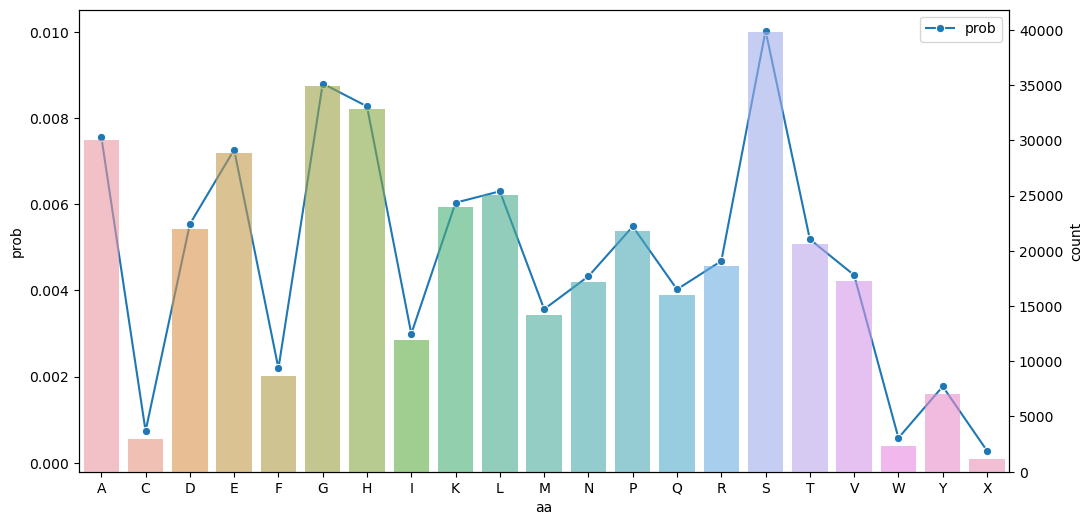

In [85]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6)) # fig use to save image to a file.

# values_a and values_b are not displayed
g1 = sns.lineplot(data = df_count_prob,  x="aa", y="prob", marker='o', sort = False, ax=ax1, label='prob')
ax2 = plt.twinx()
g2 = sns.barplot(data=df_count_prob, x="aa", y="count", alpha=0.6, ax=ax2, label='count')
plt.show()

In [89]:
fig.savefig('prob_count')

In [ ]:
df = sns.load_dataset("penguins")
sns.barplot(data=df_count_prob, x="island", y="body_mass_g")

In [16]:
prob_AAisIDR, num_AAisIDR, num_aa, num_IDR = calculate_prob(train_data)

In [17]:
print(f'The percentage of Disorder: {num_IDR/num_aa}')

The percentage of Disorder: 0.10001110258206784


In [18]:
list_pred, list_label = predict_test(prob_AAisIDR, test_data)

In [19]:
len(list_pred)

1966542

In [20]:
len(list_label)

1966542

In [23]:
from matplotlib import pyplot as plt
from sklearn import metrics
# Function that get the results from the model on the test set and plot the ROC curve
def plot_roc_curve(pred: list, label: list):
    

    fpr, tpr, thresholds = metrics.roc_curve(label, pred, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(8, 8))
    r = np.linspace(0, 1, 1000)
    fs = np.mean(np.array(np.meshgrid(r, r)).T.reshape(-1, 2), axis=1).reshape(1000, 1000)
    cs = ax.contour(r[::-1], r, fs, levels=np.linspace(0.1, 1, 10), colors='silver', alpha=0.7, linewidths=1,
                    linestyles='--')
    ax.clabel(cs, inline=True, fmt='%.1f', fontsize=20, manual=[(l, 1 - l) for l in cs.levels[:-1]])
    ax.plot(fpr, tpr, color='green', linewidth=3, label=f'AUC = %0.3f' % auc)
    ax.plot([0, 1], [0, 1], color='k', linestyle='--')
    ax.set_xlabel("FPR", fontsize=20)
    ax.set_ylabel("TPR", fontsize=20)
    plt.legend(loc='lower right', fontsize=20)
    plt.title(f'prob_model: ROC Curve', fontsize=20)
    plt.rcParams['font.size'] = 20
    plt.savefig(f'prob_model_ROC_curve.png')
    # plt.show()
    
    return fig

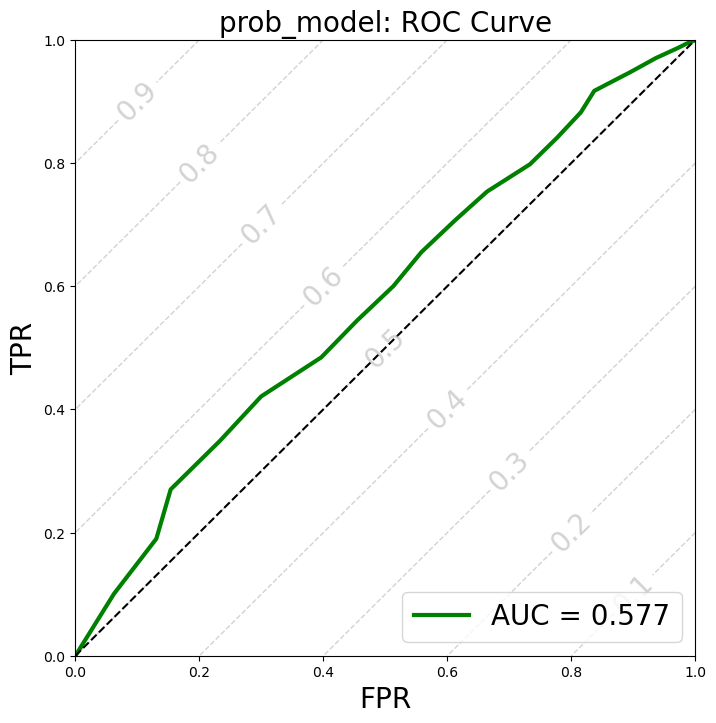

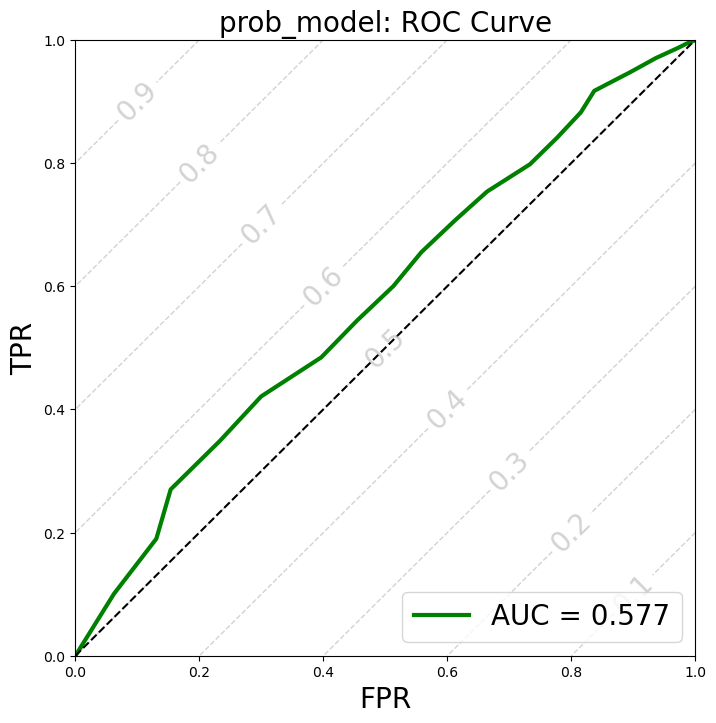

In [28]:
plot_roc_curve(list_pred, list_label)